# Continuity-preserving simplification of triangular artifacts

This notebook contains experiments simplifying triangular artifacts while preserving continuity of the network.

In [1]:
import folium
import geopandas as gpd
import matplotlib.pyplot as plt
import momepy
import numpy as np
import pandas as pd
import shapely
import utils
from folium import plugins
from libpysal import graph
from scipy import sparse

Specify case metadata

In [2]:
case = "Liège"

Read road data

In [3]:
roads = utils.read_parquet_roads(case)

Remove false nodes (nodes with degree 2)

In [4]:
%%time
roads = momepy.remove_false_nodes(roads)

CPU times: user 34.6 s, sys: 71.8 ms, total: 34.7 s
Wall time: 35.2 s


/Users/martin/miniforge3/envs/simplification/lib/python3.11/site-packages/geopandas/array.py:1459: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as unknown (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))


Measure continuity of street network

In [5]:
%%time
coins = momepy.COINS(roads)

CPU times: user 2.2 s, sys: 31.5 ms, total: 2.23 s
Wall time: 2.28 s


Assing continuity group

In [6]:
%%time
roads["coins_group"] = coins.stroke_attribute()

CPU times: user 4.48 s, sys: 16.1 ms, total: 4.5 s
Wall time: 4.58 s


Assign length of each continuity group and a number of segments within the group.

In [7]:
coins_grouped = roads.length.groupby(roads.coins_group)
roads["coins_len"] = coins_grouped.sum()[roads.coins_group].values
roads["coins_count"] = coins_grouped.size()[roads.coins_group].values

Read artifacts

In [8]:
artifacts = gpd.read_parquet(
    f"../data/{utils.city_fua[case]}/polygons", columns=["geometry", "is_artifact"]
)
artifacts = artifacts[artifacts.is_artifact].reset_index(drop=True)
artifacts["id"] = artifacts.index

Get nodes from the network.

In [9]:
first = shapely.get_point(roads.geometry, 0)
last = shapely.get_point(roads.geometry, -1)
possible_nodes = gpd.GeoSeries(
    pd.concat([first, last], ignore_index=True), crs=roads.crs
)
nodes = possible_nodes[~possible_nodes.duplicated()]

Link nodes to artifacts

In [10]:
node_idx, artifact_idx = artifacts.sindex.query(
    nodes.buffer(0.1), predicate="intersects"
)
intersects = sparse.coo_array(
    ([True] * len(node_idx), (node_idx, artifact_idx)),
    shape=(len(nodes), len(artifacts)),
    dtype=np.bool_,
)

Filter out triangles, i.e. artifacts with three entry points.

In [11]:
triangles = artifacts[intersects.sum(axis=0) == 3]

Figure out which segments are on the ends of their continuity groups.

In [12]:
roads_contiguity = graph.Graph.build_contiguity(roads, rook=False).assign_self_weight()
grouper = roads.coins_group.take(roads_contiguity._adjacency.index.codes[1]).groupby(
    roads_contiguity._adjacency.index.codes[0]
)
coins_end = []
for i, g in grouper:
    coins_end.append((g == g.loc[i]).sum() in (1, 2))
roads["coins_end"] = coins_end

In [ ]:
m = roads.explore(
    "coins_len",
    k=20,
    scheme="quantiles",
    tiles="cartodb positron",
    prefer_canvas=True,
    name="Roads",
    highlight_kwds={"color": "red"},
)
triangles.explore(m=m, name="Artifacts")
nodes.explore(m=m, name="Nodes", color="red")
folium.LayerControl().add_to(m)
plugins.MousePosition().add_to(m)

m

### Case 1

If one edge is its own contiuity group while the other two are part of larger continuity blocks where one continues before and after the artifact

- If the shortest line from the entry point to the street that continues before and after the artifact is singificantly shorter than the existing connection use that one
- If the shortest line from the entry point to the street that continues before and after the artifact is not singificantly shorter than the existing connection, use the existing connection

<Axes: >

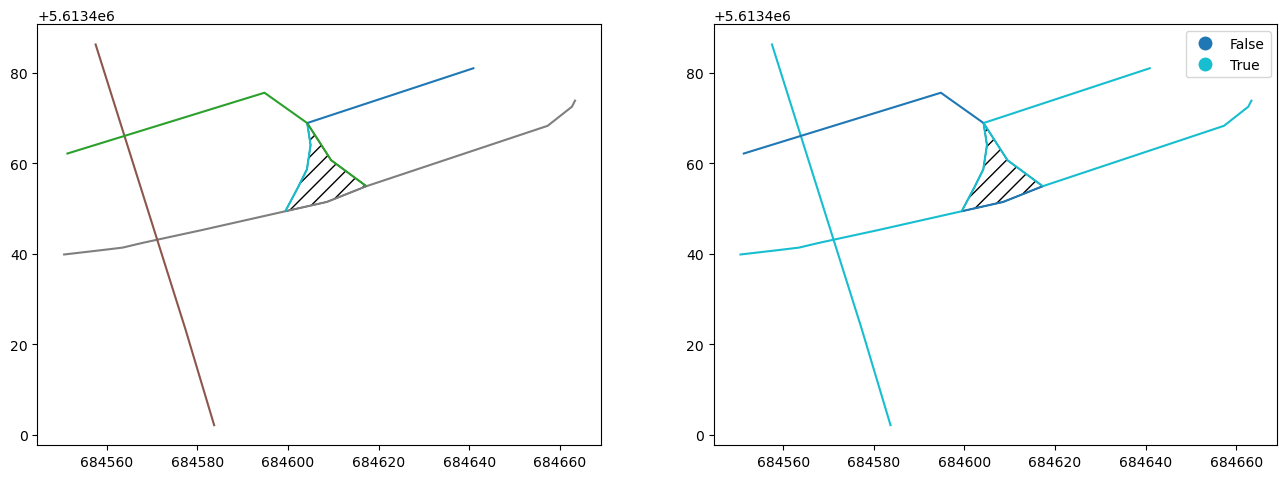

In [14]:
geom = triangles.geometry[[4160]]
distance_threshold = 1.05

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

geom.plot(hatch="//", ax=axs[0], color="none")
roads.clip(geom.buffer(50)).plot("coins_group", ax=axs[0], categorical=True)
geom.plot(hatch="//", ax=axs[1], color="none")
roads.clip(geom.buffer(50)).plot("coins_end", ax=axs[1], categorical=True, legend=True)

Get relevant edges to work with and assert this is indeed the specific case

In [15]:
edges = roads.iloc[roads.sindex.query(geom.item(), predicate="covers")]

assert len(edges) == 3  # ensure triangle
assert edges.coins_end.sum() == 2  # one continuity block continues before and after
assert (edges.coins_count == 1).sum() == 1  # one continuity block is a single edge

Extract nodes, identify the main road and an entry node on the other side. Generate the shortest line.

In [16]:
relevant_nodes = nodes.iloc[nodes.sindex.query(geom.item(), predicate="intersects")]
main_road = edges.geometry[~edges.coins_end].item()
entry_node = relevant_nodes[relevant_nodes.disjoint(main_road)]
shortest_line = shapely.shortest_line(entry_node.item(), main_road)

Mark the unnecessary edge for removal.

In [17]:
to_drop = []
to_add = []

to_drop.append((edges.coins_count == 1).idxmax())

Check if the shortest line is shorter than the existing connection.

In [18]:
edges_fixed = edges[edges.coins_count != 1]
existing_link = edges_fixed.geometry[edges_fixed.coins_end]

if shortest_line.length * distance_threshold < existing_link.length.item():
    to_drop.append(existing_link.index[0])
    to_add.append(shortest_line)

**TODO**: ensure the existing link gets split into two segments.

Generate new road data

In [19]:
new_roads = pd.concat(
    [roads.geometry.drop(to_drop), gpd.GeoSeries(to_add, crs=roads.crs)]
)

Verify

<Axes: >

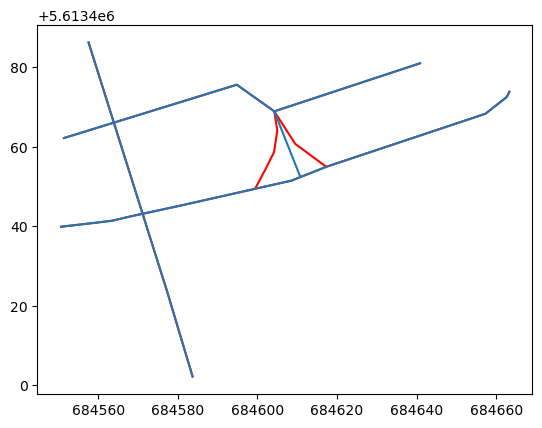

In [20]:
ax = new_roads.clip(geom.buffer(50)).plot(zorder=2)
roads.clip(geom.buffer(50)).plot(ax=ax, color="red", zorder=1)

### Case 2

If one edge is its own contiuity group while the other two are part of larger continuity blocks where both continue before and after the artifact
- drop the edge that is its own continuity group

<Axes: >

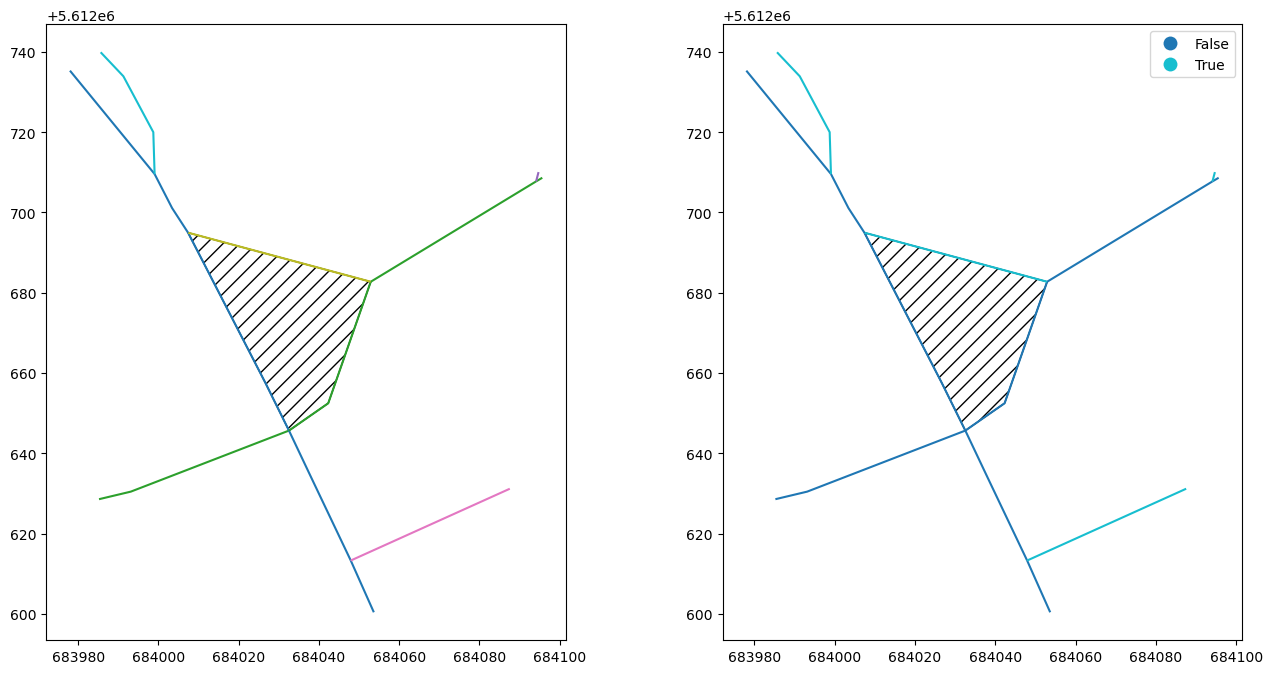

In [21]:
geom = triangles.geometry[[3140]]

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

geom.plot(hatch="//", ax=axs[0], color="none")
roads.clip(geom.buffer(50)).plot("coins_group", ax=axs[0], categorical=True)
geom.plot(hatch="//", ax=axs[1], color="none")
roads.clip(geom.buffer(50)).plot("coins_end", ax=axs[1], categorical=True, legend=True)

Get relevant edges to work with and assert this is indeed the specific case

In [22]:
edges = roads.iloc[roads.sindex.query(geom.item(), predicate="covers")]

assert len(edges) == 3  # ensure triangle
assert edges.coins_end.sum() == 1  # two continuity blocks continue before and after
assert (edges.coins_count == 1).sum() == 1  # one continuity block is a single edge

Drop the edge that is its own continuity group

In [23]:
to_drop = []
to_add = []

to_drop.append((edges.coins_count == 1).idxmax())

Generate new road data

In [24]:
new_roads = pd.concat(
    [roads.geometry.drop(to_drop), gpd.GeoSeries(to_add, crs=roads.crs)]
)

Verify

<Axes: >

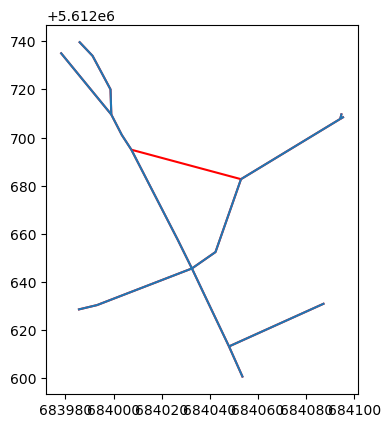

In [25]:
ax = new_roads.clip(geom.buffer(50)).plot(zorder=2)
roads.clip(geom.buffer(50)).plot(ax=ax, color="red", zorder=1)

### Case 3

If two edges are their own continuity groups while the third is part of a larger continuity block:
- drop the two edges that are their own continuity groups and link the entry point to the larger continuity block

**NOTE**: this is a theoretical situation, I am not sure COINS can result in this

### Case 4

If all three edges are their own continuity groups:
- drop all of them and link entry points to the centroid of the triangle

**NOTE**: this is a theoretical situation, I am not sure COINS can result in this

### Case 5

If all three edges are part of larger continuity blocks & only one of them is part of a continuity block that continues before and after the artifact:
- if one of the non-primary continuity blocks intersects the primary
    - keep the existing node between the two continuity blocks, remove the remaining edge
- if the non-primary continuity blocks do not intersect the primary
    - drop the two and link the entry point to the continuity block that continues before and after the artifact

#### Case 5.1 (intersects)

<Axes: >

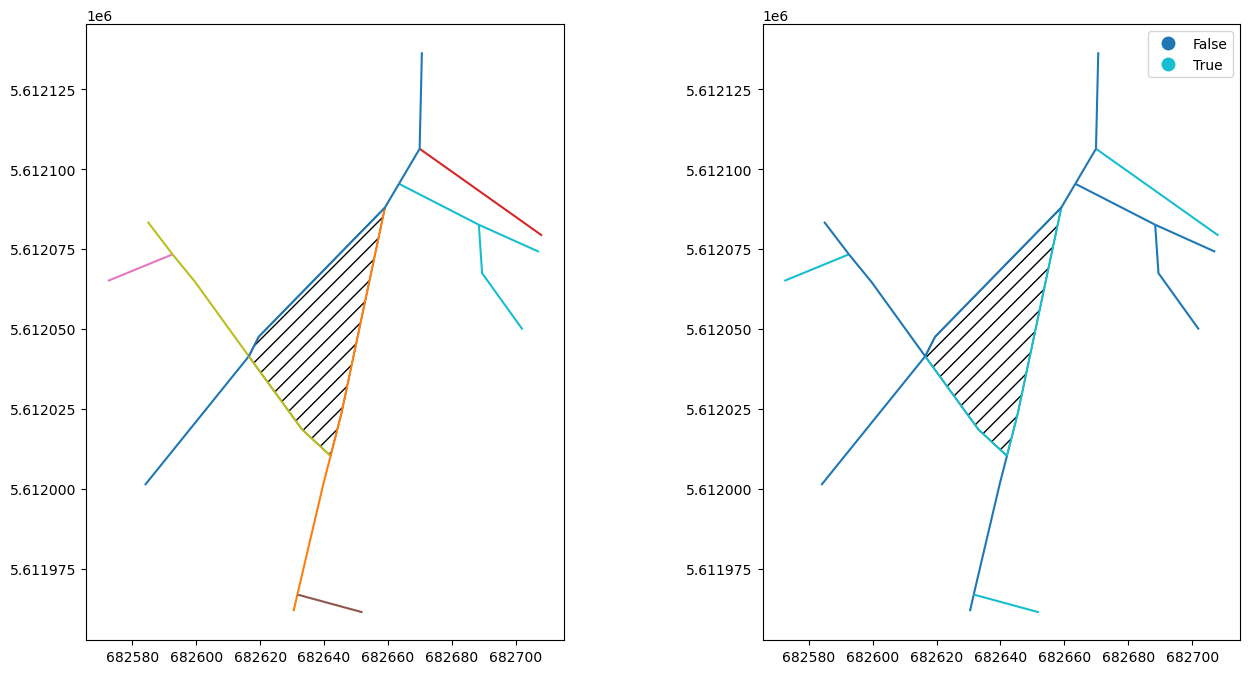

In [26]:
geom = triangles.geometry[[4017]]

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

geom.plot(hatch="//", ax=axs[0], color="none")
roads.clip(geom.buffer(50)).plot("coins_group", ax=axs[0], categorical=True)
geom.plot(hatch="//", ax=axs[1], color="none")
roads.clip(geom.buffer(50)).plot("coins_end", ax=axs[1], categorical=True, legend=True)

Get relevant edges to work with and assert this is indeed the specific case. Also get edges that go beyond the artifact.

In [27]:
edges_extended = roads.iloc[roads.sindex.query(geom.item(), predicate="intersects")]
edges = edges_extended.iloc[
    edges_extended.sindex.query(geom.item(), predicate="covers")
]

assert len(edges) == 3  # ensure triangle
assert edges.coins_end.sum() == 2  # one continuity block continues before and after
assert (edges.coins_count == 1).sum() == 0  # no continuity block is a single edge

Identify main and non-main roads.

In [28]:
main_road = edges[~edges.coins_end]
main_group = main_road.coins_group.item()
non_main = edges_extended[edges_extended.coins_group != main_group]

Check whether some of the other continuity groups intersect with the main one. If so, mark the edge of the group that does not intersect for removal. Otherwise, mark both for removal and replace them with the shortest line.

In [29]:
to_drop = []
to_add = []

intersections_per_group = (
    non_main.intersects(main_road.geometry.item()).groupby(non_main.coins_group).sum()
    > 1
)

if intersections_per_group.any():
    group_to_drop = intersections_per_group.idxmin()
    to_drop.append(edges[edges.coins_group == group_to_drop].index[0])
else:
    relevant_nodes = nodes.iloc[nodes.sindex.query(geom.item(), predicate="intersects")]
    entry_node = relevant_nodes[relevant_nodes.disjoint(main_road.geometry.item())]
    shortest_line = shapely.shortest_line(entry_node.item(), main_road.geometry.item())

    to_add.append(shortest_line)
    to_drop.extend(edges[edges.coins_group != main_group].index.to_list())

Generate new road data

In [30]:
new_roads = pd.concat(
    [roads.geometry.drop(to_drop), gpd.GeoSeries(to_add, crs=roads.crs)]
)

Verify

<Axes: >

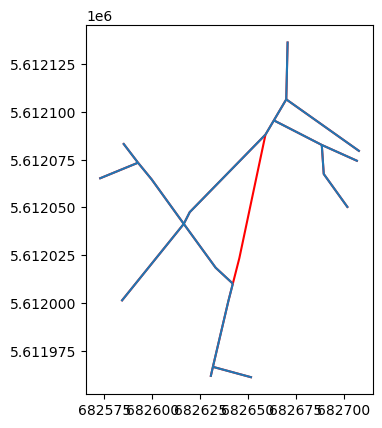

In [31]:
ax = new_roads.clip(geom.buffer(50)).plot(zorder=2)
roads.clip(geom.buffer(50)).plot(ax=ax, color="red", zorder=1)

#### Case 5.2

<Axes: >

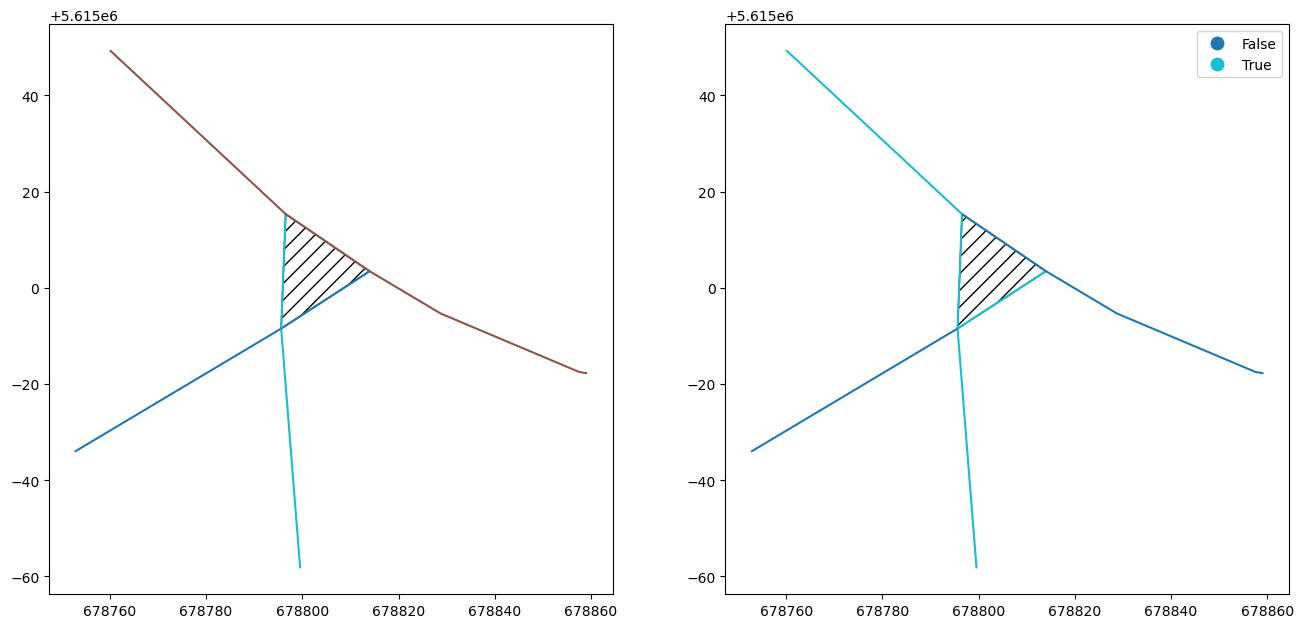

In [32]:
geom = triangles.geometry[[385]]

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

geom.plot(hatch="//", ax=axs[0], color="none")
roads.clip(geom.buffer(50)).plot("coins_group", ax=axs[0], categorical=True)
geom.plot(hatch="//", ax=axs[1], color="none")
roads.clip(geom.buffer(50)).plot("coins_end", ax=axs[1], categorical=True, legend=True)

Get relevant edges to work with and assert this is indeed the specific case. Also get edges that go beyond the artifact.

In [33]:
edges_extended = roads.iloc[roads.sindex.query(geom.item(), predicate="intersects")]
edges = edges_extended.iloc[
    edges_extended.sindex.query(geom.item(), predicate="covers")
]

assert len(edges) == 3  # ensure triangle
assert edges.coins_end.sum() == 2  # one continuity block continues before and after
assert (edges.coins_count == 1).sum() == 0  # no continuity block is a single edge

Identify main and non-main roads.

In [34]:
main_road = edges[~edges.coins_end]
main_group = main_road.coins_group.item()
non_main = edges_extended[edges_extended.coins_group != main_group]

Check whether some of the other continuity groups intersect with the main one. If so, mark the edge of the group that does not intersect for removal. Otherwise, mark both for removal and replace them with the shortest line.

In [35]:
to_drop = []
to_add = []

intersections_per_group = (
    non_main.intersects(main_road.geometry.item()).groupby(non_main.coins_group).sum()
    > 1
)

if intersections_per_group.any():
    group_to_drop = intersections_per_group.idxmin()
    to_drop.append(edges[edges.coins_group == group_to_drop].index[0])
else:
    relevant_nodes = nodes.iloc[nodes.sindex.query(geom.item(), predicate="intersects")]
    entry_node = relevant_nodes[relevant_nodes.disjoint(main_road.geometry.item())]
    shortest_line = shapely.shortest_line(entry_node.item(), main_road.geometry.item())

    to_add.append(shortest_line)
    to_drop.extend(edges[edges.coins_group != main_group].index.to_list())

Generate new road data

In [36]:
new_roads = pd.concat(
    [roads.geometry.drop(to_drop), gpd.GeoSeries(to_add, crs=roads.crs)]
)

**TODO**: ensure the existing link gets split into two segments.

Verify

<Axes: >

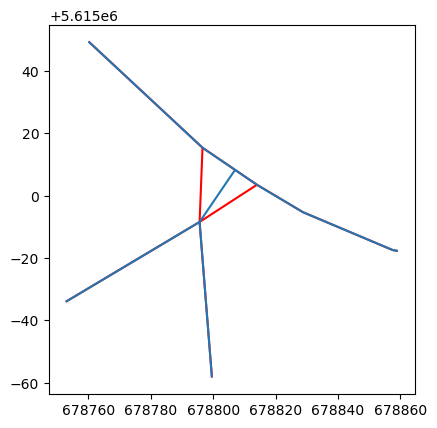

In [37]:
ax = new_roads.clip(geom.buffer(50)).plot(zorder=2)
roads.clip(geom.buffer(50)).plot(ax=ax, color="red", zorder=1)

### Case 6

If all three edges are part of larger continuity blocks & two of them are part of a continuity block that continues before and after the artifact
- drop the one that is not part of a continuity block that continues before and after the artifact

<Axes: >

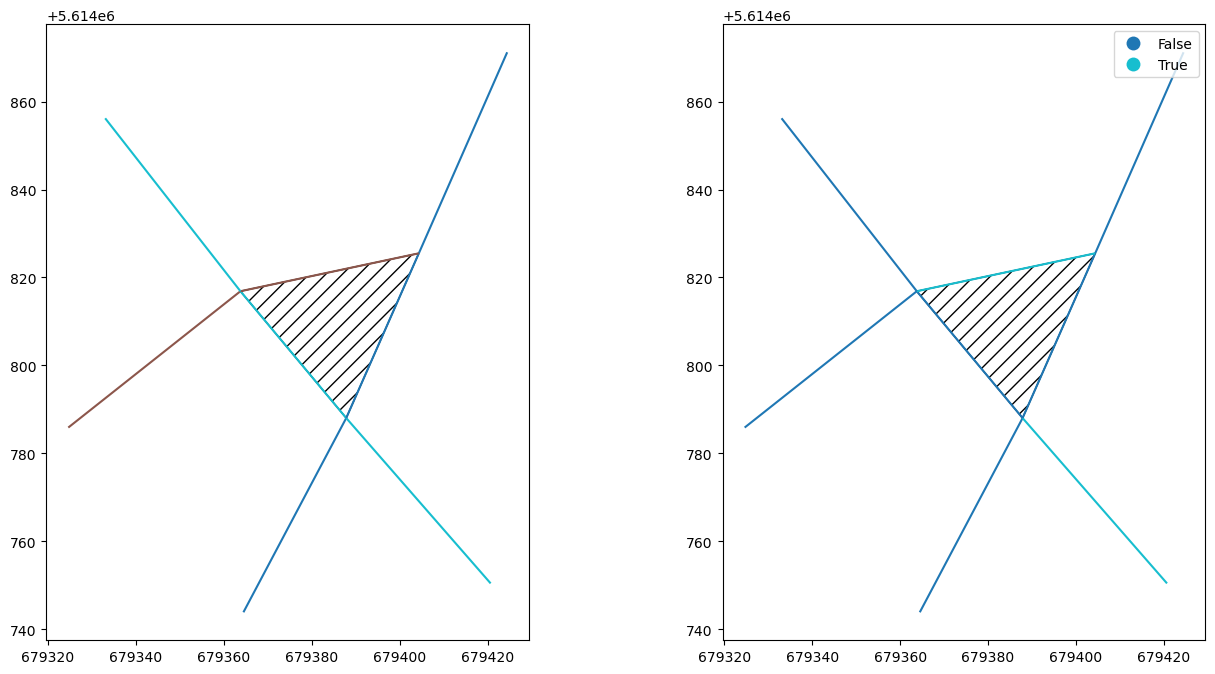

In [38]:
geom = triangles.geometry[[353]]

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

geom.plot(hatch="//", ax=axs[0], color="none")
roads.clip(geom.buffer(50)).plot("coins_group", ax=axs[0], categorical=True)
geom.plot(hatch="//", ax=axs[1], color="none")
roads.clip(geom.buffer(50)).plot("coins_end", ax=axs[1], categorical=True, legend=True)

Get relevant edges to work with and assert this is indeed the specific case

In [39]:
edges = roads.iloc[roads.sindex.query(geom.item(), predicate="covers")]

assert len(edges) == 3  # ensure triangle
assert edges.coins_end.sum() == 1  # two continuity blocks continue before and after
assert (edges.coins_count == 1).sum() == 0 # no continuity block is a single edge

Drop the only one that ends here.

In [40]:
to_drop = []
to_add = []

to_drop.append(edges[edges.coins_end].index[0])

Generate new road data

In [41]:
new_roads = pd.concat(
    [roads.geometry.drop(to_drop), gpd.GeoSeries(to_add, crs=roads.crs)]
)

Verify

<Axes: >

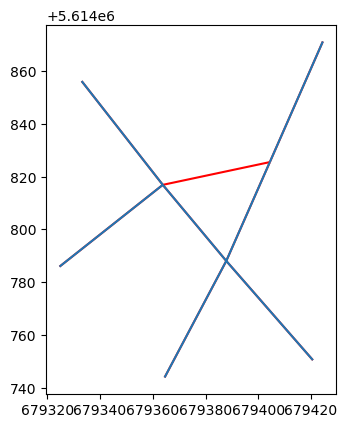

In [42]:
ax = new_roads.clip(geom.buffer(50)).plot(zorder=2)
roads.clip(geom.buffer(50)).plot(ax=ax, color="red", zorder=1)

## Case 7

If all three edges are part of larger continuity blocks & none of then continues before and after the artifact
- drop the edge with the shortest continuity block length

<Axes: >

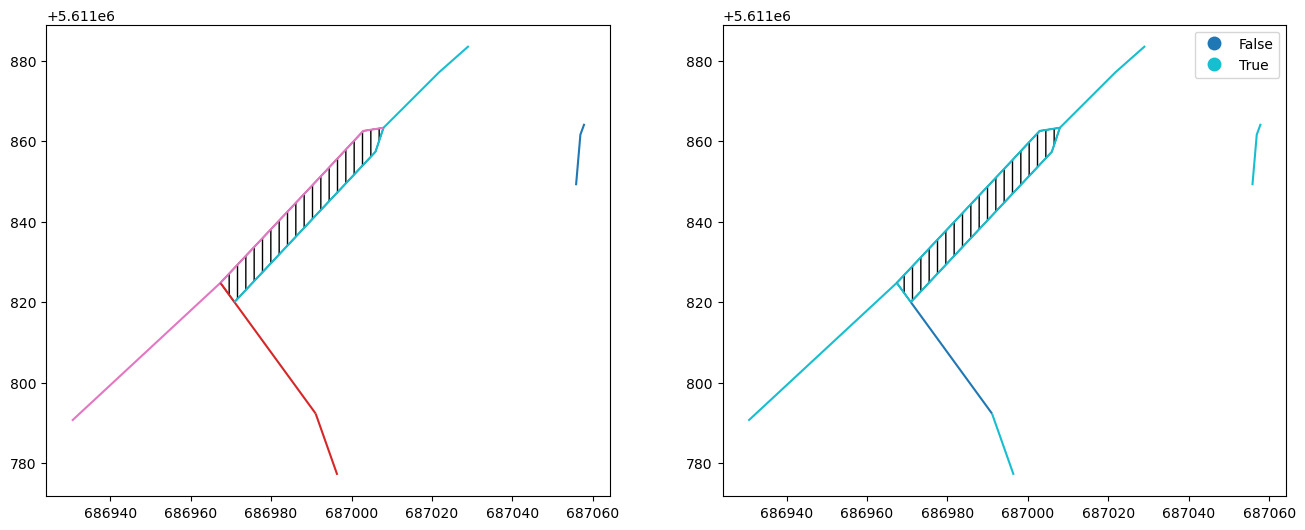

In [43]:
geom = triangles.geometry[[4129]]

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

geom.plot(hatch="||", ax=axs[0], color="none")
roads.clip(geom.buffer(50)).plot("coins_group", ax=axs[0], categorical=True)
geom.plot(hatch="||", ax=axs[1], color="none")
roads.clip(geom.buffer(50)).plot("coins_end", ax=axs[1], categorical=True, legend=True)

Get relevant edges to work with and assert this is indeed the specific case

In [44]:
edges = roads.iloc[roads.sindex.query(geom.item(), predicate="covers")]

assert len(edges) == 3  # ensure triangle
assert edges.coins_end.sum() == 3  # no continuity block continues before and after
assert (edges.coins_count == 1).sum() == 0 # no continuity block is a single edge

Drop the edge belonging to the shortest continuity group.

In [45]:
to_drop = []
to_add = []

to_drop.append(edges.coins_len.idxmin())

Generate new road data

In [46]:
new_roads = pd.concat(
    [roads.geometry.drop(to_drop), gpd.GeoSeries(to_add, crs=roads.crs)]
)

Verify

<Axes: >

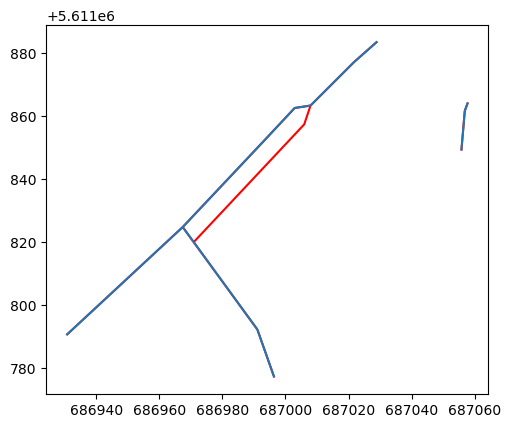

In [47]:
ax = new_roads.clip(geom.buffer(50)).plot(zorder=2)
roads.clip(geom.buffer(50)).plot(ax=ax, color="red", zorder=1)

## Case 8

If all three edges are part of the same continuiry block (roundabout):
- drop all of them and link the entry points to the centroid of the triangle

<Axes: >

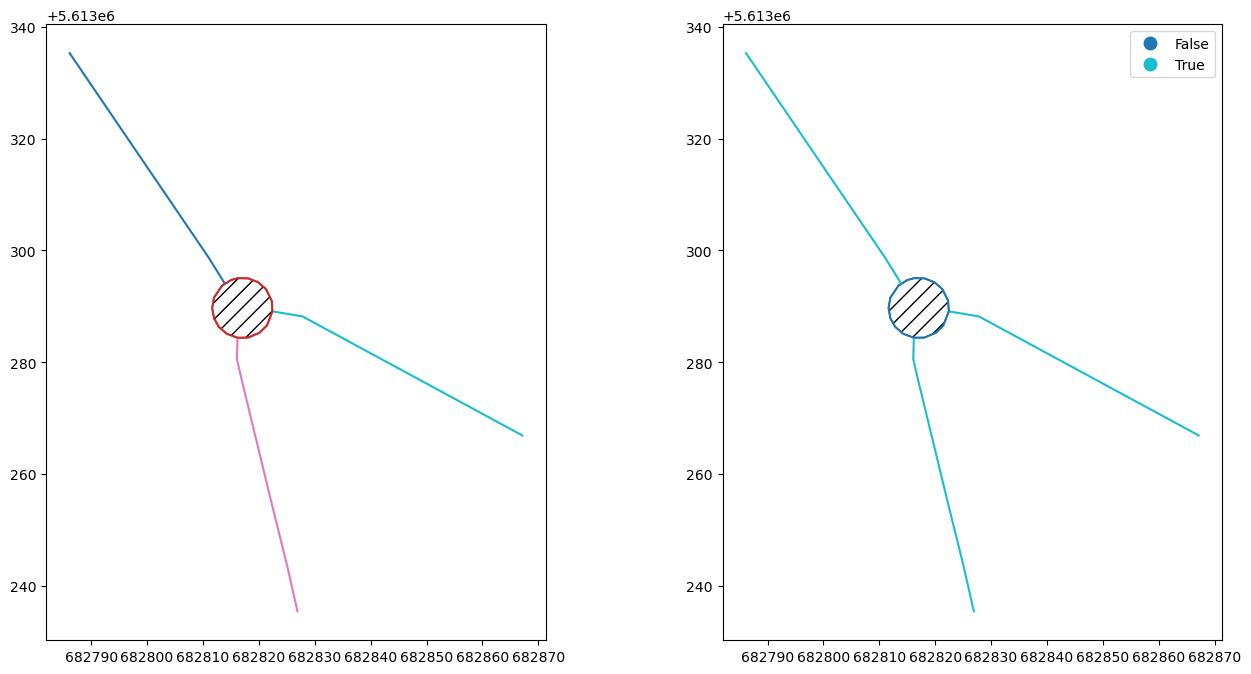

In [48]:
geom = triangles.geometry[[3595]]

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

geom.plot(hatch="//", ax=axs[0], color="none")
roads.clip(geom.buffer(50)).plot("coins_group", ax=axs[0], categorical=True)
geom.plot(hatch="//", ax=axs[1], color="none")
roads.clip(geom.buffer(50)).plot("coins_end", ax=axs[1], categorical=True, legend=True)

Get relevant edges to work with and assert this is indeed the specific case

In [49]:
edges = roads.iloc[roads.sindex.query(geom.item(), predicate="covers")]

assert len(edges) == 3  # ensure triangle
assert edges.coins_end.sum() == 0  # no ends
assert (edges.coins_count == 1).sum() == 0 # no continuity block is a single edge
assert edges.coins_group.nunique() == 1  # all edges belong to the same continuity block

Mark all for removal and replace them with shortest lines to the centroid.

In [50]:
centroid = geom.centroid.item()
relevant_nodes = nodes.iloc[nodes.sindex.query(geom.item(), predicate="intersects")]


to_drop = []
to_add = []

to_drop.extend(edges.index.to_list())
to_add.extend(shapely.shortest_line(relevant_nodes, centroid).to_list())

Generate new road data

In [51]:
new_roads = pd.concat(
    [roads.geometry.drop(to_drop), gpd.GeoSeries(to_add, crs=roads.crs)]
)

Verify

<Axes: >

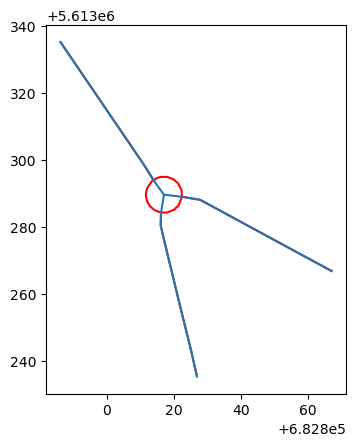

In [52]:
ax = new_roads.clip(geom.buffer(50)).plot(zorder=2)
roads.clip(geom.buffer(50)).plot(ax=ax, color="red", zorder=1)